<a href="https://colab.research.google.com/github/gabsrcha/Gabrielly_PIBIC_Lung.Node.Segmentation/blob/main/Gabs_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch import randint
!pip install torchmetrics
from torchmetrics.classification import Dice

In [89]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [90]:
transform = T.ToTensor()

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
train_images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/train/images/"))
train_mask = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/train/mask/"))
train_imgs = np.array(train_images)
train_masks = np.array(train_mask)


valid_images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/valid/images/"))
valid_mask = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/valid/mask/"))
val_imgs = np.array(valid_images)
val_masks = np.array(valid_mask)

In [93]:
def custom_collate(data):
#   data = [d for d in data if d[1]["boxes"].shape[0] > 0]
  return data

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [95]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0)

In [96]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/Gabs_lung/train/images/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/Gabs_lung/train/mask/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        #print(np.where(mask > np.min(mask)))
        for i in range(num_objs):
            #masks[i][mask == i+1] = True
            masks[i][mask > 0] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
#         print(boxes)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)


class CustDatVal(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/Gabs_lung/valid/images/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/Gabs_lung/valid/mask/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            #masks[i][mask == i+1] = True
            masks[i][mask > 0] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [97]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks),
                                 batch_size = 47,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDatVal(val_imgs , val_masks) ,
                                 batch_size = 47,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)


In [98]:
#train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks))
#val_dl = torch.utils.data.DataLoader(CustDatVal(val_imgs , val_masks))

all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(650):
    #print(epoch)
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        if len(dt) <= 1:
            print("++++",i)
            continue
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.6599, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.9666, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)}
0    2.3220558166503906    2.322514057159424
1    2.600715160369873    2.1882529258728027
2    2.142277717590332    2.3341150283813477
3    2.3247263431549072    1.902796745300293
4    2.040825605392456    2.1178979873657227
5    2.0435092449188232    2.4635469913482666
6    2.200834035873413    2.2684240341186523
7    2.245300769805908    2.1750214099884033
8    1.9654967784881592    2.118232488632202
9    1.968279480934143    2.1225152015686035
10    2.4335105419158936    1.9265501499176025
11    1.9018954038619995    1.8684091567993164
12    1.909638

In [99]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Gabs_lung/modelgabs2.pt')

In [100]:
images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/general/images/"))

In [101]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Gabs_lung/modelgabs2.pt'))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

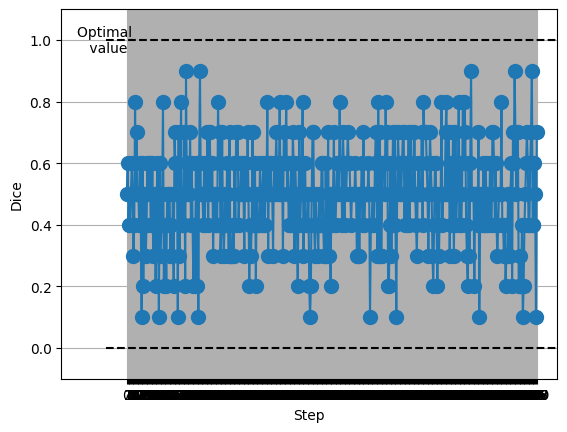

In [102]:
# Example plotting multiple values
metric = Dice()
values = [ ]
for _ in range(500):
  values.append(metric(randint(2,(10,)), randint(2,(10,))))
fig_, ax_ = metric.plot(values)

In [103]:
from torchvision.models.detection import image_list
l=0

model.eval()

#while (l<61):
#for l in range(1,len(images)):
for l in images:
    print(l)
    img = Image.open("/content/drive/MyDrive/Gabs_lung/general/images/"+str(l))
    transform = T.ToTensor()
    ig = transform(img)
    with torch.no_grad():
        pred = model([ig.to(device)])
        plt.imshow((pred[0]["masks"][0].cpu().detach().numpy()*255).astype("uint8").squeeze(), cmap='gray')
        plt.axis('off')
        plt.savefig("/content/drive/MyDrive/Gabs_lung/test/"+str(l), format='png', bbox_inches='tight',pad_inches=0)



1.png


IndexError: ignored